#**Análisis de serie de tiempo y modelado usando métodos clásicos**

### **Preparar el notebook**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### **Cargar los datos preparados**

In [5]:
dfsuro = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_suroeste.csv')

In [6]:
print(dfsuro.shape)
dfsuro.head()

(4117, 16)


,Unnamed: 0,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo
0,3,14962964.0,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT
1,10,4946322.0,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
2,11,11918713.0,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
3,153,13222653.0,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT
4,156,4916076.0,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT


In [7]:
dfsuro.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [8]:
# Dar formato al campo FECHA
dfsuro['FECHA'] = pd.to_datetime(dfsuro['FECHA'], format='%Y-%m-%d %H:%M:%S.%f')
# Dar formato al campo ID
dfsuro['ID'] = dfsuro['ID'].astype(int)

In [9]:
dfsuro.dtypes

ID                            int64
ELEMENTO                     object
NODO                        float64
FECHA                datetime64[ns]
COORD_LONG                  float64
COORD_LAT                   float64
REGION                       object
SUBREGION                    object
GRUPO_RESPONSABLE            object
CRITICIDAD_NUM              float64
MUNICIPIO                   float64
CIRCUITO                     object
PENDIENTE                    object
ESTADO                       object
tipo                         object
dtype: object

### **Análisis de la serie de tiempo con frecuencia semanal**

In [10]:
dfsuro['fecha_semana'] = pd.to_datetime(dfsuro['FECHA']).dt.to_period('W')

In [11]:
dfsuro.head()

,ID,ELEMENTO,NODO,FECHA,COORD_LONG,COORD_LAT,REGION,SUBREGION,GRUPO_RESPONSABLE,CRITICIDAD_NUM,MUNICIPIO,CIRCUITO,PENDIENTE,ESTADO,tipo,fecha_semana
0,14962964,FR46394,NaN,2023-02-10 20:34:35,-76.031442,6.135418,SUROESTE,AMAGA,DE25,64.0,5847.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2023-02-06/2023-02-12
1,4946322,F54128,NaN,2021-02-27 16:17:36,-75.949641,6.176642,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2021-02-22/2021-02-28
2,11918713,FR5175,NaN,2022-08-05 07:22:47,-75.945599,6.222647,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-08-01/2022-08-07
3,13222653,FR5144,553018.0,2022-10-14 16:36:05,-75.990291,6.171016,SUROESTE,AMAGA,DE25,64.0,5093.0,507-12,TRABAJOS DE PODA,CERRADA,OT,2022-10-10/2022-10-16
4,4916076,F54165,NaN,2021-02-20 14:04:59,-75.918451,5.997762,SUROESTE,AMAGA,DE25,64.0,5209.0,518-13,TRABAJOS DE PODA,CANCELADA,OT,2021-02-15/2021-02-21


Se extrae la serie semanal, haciendo el conteo de eventos de Trabajos de Poda generados por semana

In [12]:
serie_suro = pd.DataFrame(dfsuro.groupby(['fecha_semana'])['ID'].count())

Se obtiene una serie con 182 observaciones

In [13]:
print(serie_suro.shape)

(182, 1)


Se renombra la columna para mayor claridad

In [14]:
serie_suro.rename(columns={'ID':'CANT_EVENTOS'},inplace=True)

In [15]:
serie_suro.head()

,CANT_EVENTOS
fecha_semana,
2019-10-28/2019-11-03,1
2019-11-04/2019-11-10,4
2019-11-11/2019-11-17,6
2019-11-18/2019-11-24,12
2019-11-25/2019-12-01,9


In [16]:
serie_suro.dtypes

CANT_EVENTOS    int64
dtype: object

<Axes: xlabel='fecha_semana'>

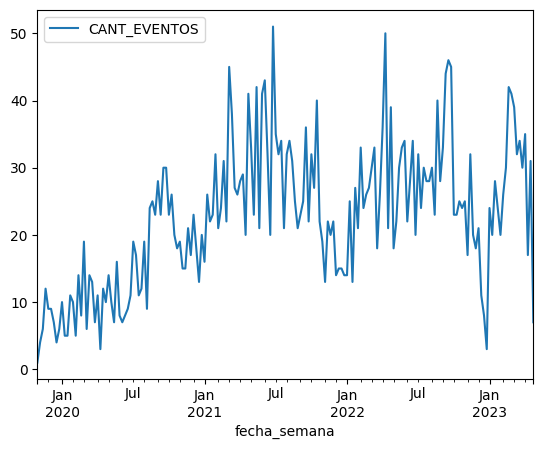

In [17]:
serie_suro.plot()

Se observa en la gráfica una tendencia creciente en la cantidad de eventos registrados. Esto se debe a un subregistro de los eventos en la etapa inicial de estabilización del sistema donde se almacenan los datos. Con el fin de evitar sesgos en las estimaciones se eliminarán los registros correspondientes a este periodo de estabilización

In [18]:
#Seleccionamos los datos de la serie que se usarán.
serie_suro=serie_suro.iloc[44:-1]
serie_suro

,CANT_EVENTOS
fecha_semana,
2020-08-31/2020-09-06,28
2020-09-07/2020-09-13,23
2020-09-14/2020-09-20,30
2020-09-21/2020-09-27,30
2020-09-28/2020-10-04,23
...,...
2023-03-13/2023-03-19,34
2023-03-20/2023-03-26,30
2023-03-27/2023-04-02,35


<Axes: xlabel='fecha_semana'>

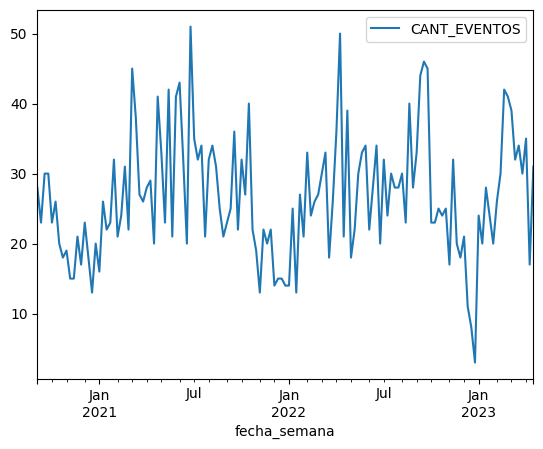

In [19]:
serie_suro.plot()

####**Transformación del conjunto de datos e incorporación de otras variables**

Se realiza una transformación de los datos para convertirlos a una estructura que facilite la aplicació de los modelos de aprendizaje automático

En primer lugar se modifica el índice de la serie de tiempo, correspondiente a un rango semanal, conservando únicamente la fecha inicial.

In [20]:
serie_suro.index = serie_suro.index.to_timestamp()

In [21]:
serie_suro.CANT_EVENTOS

fecha_semana
2020-08-31    28
2020-09-07    23
2020-09-14    30
2020-09-21    30
2020-09-28    23
              ..
2023-03-13    34
2023-03-20    30
2023-03-27    35
2023-04-03    17
2023-04-10    31
Freq: W-MON, Name: CANT_EVENTOS, Length: 137, dtype: int64

 Se crea una variable *dummy* que refleje la condición de indisponibilidad del sistema de información donde se crean los eventos y se almacenan los datos (fechas donde han ocurrido este tipo de situaciones).

In [22]:
#Se crea sobre el dataframe original una variable dummy con valor 1 
#para las fechas donde se tiene conocimiento de situaciones de indisponibilidad del sistema de información
serie_suro['DUMMY'] = np.where(serie_suro.index.isin(['2022-12-19 00:00:00', '2022-12-12 00:00:00', '2022-12-05 00:00:00']), 1, 0)

<ipython-input-22-effb6422a357>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['DUMMY'] = np.where(serie_suro.index.isin(['2022-12-19 00:00:00', '2022-12-12 00:00:00', '2022-12-05 00:00:00']), 1, 0)


**Datos de precipitaciones**

Como parte del entendimiento del negocio, se ha identificado una posible relación entre la cantidad de precipitaciones en la zona geográfica de estudio y la generación de eventos de poda en las redes de distribución.

Considerando lo anterior, se ha determinado incluir en el modelado los datos de precipitaciones capturados por cuatro estaciones de monitoreo ubicadas en la región en interés.

In [23]:
#Carga de los datos
df = pd.read_csv('/content/drive/MyDrive/ProyectoIntegrador2/Precipitaciones/precipitacion_suroeste.csv', encoding='latin-1')

In [24]:
precipitacion=df[['NombreEstacion','Fecha','Valor']]
precipitacion['Fecha'] = pd.to_datetime(precipitacion['Fecha'])
precipitacion

<ipython-input-24-f854ac561c41>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitacion['Fecha'] = pd.to_datetime(precipitacion['Fecha'])


,NombreEstacion,Fecha,Valor
0,BOLOMBOLO [26200130],2020-08-24,24.7
1,BOLOMBOLO [26200130],2020-08-25,0.0
2,BOLOMBOLO [26200130],2020-08-26,2.7
3,BOLOMBOLO [26200130],2020-08-27,0.0
4,BOLOMBOLO [26200130],2020-08-28,2.4
...,...,...,...
3849,URRAO [11075020],2023-04-12,4.5
3850,URRAO [11075020],2023-04-13,12.5
3851,URRAO [11075020],2023-04-14,0.0
3852,URRAO [11075020],2023-04-15,1.2


In [25]:
#Obtener la serie de datos para cada una de las estaciones de monitoreo

bolombolo=precipitacion[precipitacion['NombreEstacion']=='BOLOMBOLO [26200130]']
santabarbara=precipitacion[precipitacion['NombreEstacion']=='SANTA BARBARA [26190100]']
fredonia=precipitacion[precipitacion['NombreEstacion']=='FREDONIA [26200150]']
urrao=precipitacion[precipitacion['NombreEstacion']=='URRAO [11075020]']

In [26]:
#Agrupar los datos de precipitaciones en forma semanal 
#con el fin de darles la misma periodicidad de muestreo de la serie de datos de eventos
bolombolo_semanal = bolombolo.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
santabarbara_semanal = santabarbara.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
fredonia_semanal = fredonia.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()
urrao_semanal = urrao.groupby([pd.Grouper(key='Fecha', freq='W')])['Valor'].sum()

In [27]:
#Se adicionan los datos de precipitaciones al dataframe original
serie_suro['bolombolo'] = bolombolo_semanal[1:].values
serie_suro['santabarbara'] = santabarbara_semanal[1:].values
serie_suro['fredonia'] = fredonia_semanal[1:].values
serie_suro['urrao'] = urrao_semanal[1:].values

<ipython-input-27-a3830f9f264e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['bolombolo'] = bolombolo_semanal[1:].values
<ipython-input-27-a3830f9f264e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['santabarbara'] = santabarbara_semanal[1:].values
<ipython-input-27-a3830f9f264e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

**Adicionar el trimestre como variable predictora para modelar la estacionalidad de los datos**

In [28]:
serie_suro['trimestre'] = serie_suro.index.quarter

<ipython-input-28-ded73e068546>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie_suro['trimestre'] = serie_suro.index.quarter


In [29]:
df_one_hot = pd.get_dummies(serie_suro['trimestre'], prefix='trimestre')
df_one_hot

,trimestre_1,trimestre_2,trimestre_3,trimestre_4
fecha_semana,,,,
2020-08-31,0,0,1,0
2020-09-07,0,0,1,0
2020-09-14,0,0,1,0
2020-09-21,0,0,1,0
2020-09-28,0,0,1,0
...,...,...,...,...
2023-03-13,1,0,0,0
2023-03-20,1,0,0,0
2023-03-27,1,0,0,0


In [30]:
serie_suro = pd.concat([serie_suro, df_one_hot], axis=1)

In [31]:
serie_suro.drop('trimestre', axis = 1, inplace=True)

Ahora el conjunto de datos se compone de:
* la cantidad de eventos de poda ocurridos
* las precipitaciones registradas por las estaciones de monitoreo en la zona de interés
* la condición de indisponibilidad del sistema de información donde se registran los eventos
* el trimestre correspondiente a la fecha del registro

In [32]:
serie_suro

,CANT_EVENTOS,DUMMY,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
fecha_semana,,,,,,,,,,
2020-08-31,28,0,43.3,44.5,73.0,63.6,0,0,1,0
2020-09-07,23,0,34.3,24.6,124.0,16.8,0,0,1,0
2020-09-14,30,0,37.8,44.4,77.0,55.9,0,0,1,0
2020-09-21,30,0,71.7,39.9,67.0,12.7,0,0,1,0
2020-09-28,23,0,78.3,47.0,130.0,64.1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
2023-03-13,34,0,68.0,63.0,112.0,24.7,1,0,0,0
2023-03-20,30,0,0.0,19.8,13.0,3.1,1,0,0,0
2023-03-27,35,0,2.4,49.2,45.0,14.4,1,0,0,0


**Exportar el conjunto de datos**

In [33]:
serie_suro.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/datos_serietiempo.csv')

### **Modelado de la serie de tiempo**

**Dividir el conjunto de datos en set de entrenamiento y set de prueba**

In [34]:
#se define el número de periodos que serán usados como conjunto de datos de entrenamiento

Ntest = 12
train_exog = serie_suro.iloc[:-Ntest]
test_exog = serie_suro.iloc[-Ntest:]

In [36]:
train_idx = serie_suro.index <= train_exog.index[-1]
test_idx = serie_suro.index > train_exog.index[-1]

In [37]:
test_exog.tail()

,CANT_EVENTOS,DUMMY,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4
fecha_semana,,,,,,,,,,
2023-03-13,34,0,68.0,63.0,112.0,24.7,1,0,0,0
2023-03-20,30,0,0.0,19.8,13.0,3.1,1,0,0,0
2023-03-27,35,0,2.4,49.2,45.0,14.4,1,0,0,0
2023-04-03,17,0,5.4,76.5,26.0,1.0,0,1,0,0
2023-04-10,31,0,20.8,59.9,27.0,30.2,0,1,0,0


#### **Modelo ARIMAX**


Modelo de serie de tiempo incluyendo las variables exógenas: las precipitaciones y  la condición de indisponibilidad del sistema de información.

Para el modelo se utiliza el orden de los procesos entregado por el modelo **AUTOARIMA**

In [38]:
columns = ['DUMMY', 'bolombolo', 'santabarbara', 'fredonia', 'urrao', 'trimestre_1', 'trimestre_2', 'trimestre_3', 'trimestre_4']

In [39]:
#Se define el modelo y se ajusta sobre el conjunto de datos de entrenamiento
model_ARIMAX = SARIMAX(train_exog.CANT_EVENTOS, exog=train_exog[columns], order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
model_ARIMAX_fit = model_ARIMAX.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
print(model_ARIMAX_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           CANT_EVENTOS   No. Observations:                  125
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -417.258
Date:                Tue, 06 Jun 2023   AIC                            858.516
Time:                        18:36:07   BIC                            892.456
Sample:                    08-31-2020   HQIC                           872.304
                         - 01-16-2023                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
DUMMY          -11.6290      9.724     -1.196      0.232     -30.688       7.430
bolombolo        0.0242      0.027      0.889      0.374      -0.029       0.078
santabarbara     0.0297      0.032      0.93

In [41]:
#Se hace la predicción de los valores para el conjunto de datos de entrenamiento y se almacena en el dataframe original
serie_suro.loc[train_idx, 'ARIMAX'] = model_ARIMAX_fit.predict(start = train_exog.index[0], end= train_exog.index[-1], exog=train_exog[columns])


In [42]:
serie_suro.head()

,CANT_EVENTOS,DUMMY,bolombolo,santabarbara,fredonia,urrao,trimestre_1,trimestre_2,trimestre_3,trimestre_4,ARIMAX
fecha_semana,,,,,,,,,,,
2020-08-31,28,0,43.3,44.5,73.0,63.6,0,0,1,0,29.319069
2020-09-07,23,0,34.3,24.6,124.0,16.8,0,0,1,0,27.886168
2020-09-14,30,0,37.8,44.4,77.0,55.9,0,0,1,0,28.769078
2020-09-21,30,0,71.7,39.9,67.0,12.7,0,0,1,0,29.431286
2020-09-28,23,0,78.3,47.0,130.0,64.1,0,0,1,0,29.842223


In [43]:
#Se obtiene la predicción para el conjunto de datos de prueba
prediction_ARIMAX = model_ARIMAX_fit.get_prediction(steps = 12, exog=test_exog[columns])

In [44]:
#Se almacena el resultado de la predicción en el dataframe original
serie_suro.loc[test_idx, 'ARIMAX'] = model_ARIMAX_fit.get_forecast(steps = 12, exog=test_exog[columns]).predicted_mean


In [45]:
#Se define una función para el ajuste del modelo y para graficar los resultados
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize = (10,4))
    ax.plot(serie_suro['CANT_EVENTOS'], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train_exog.index, train_pred, color = 'green', label = 'fitted')
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest, exog=test_exog[columns])
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower CANT_EVENTOS'], conf_int['upper CANT_EVENTOS']
    forecast = prediction_result.predicted_mean
    ax.plot(test_exog.index, forecast, label = 'Forecast')
    ax.fill_between(test_exog.index, lower, upper, color = 'red', alpha = 0.3)
    
    ax.legend()

**Gráfica del resultado del modelo ARIMAX**

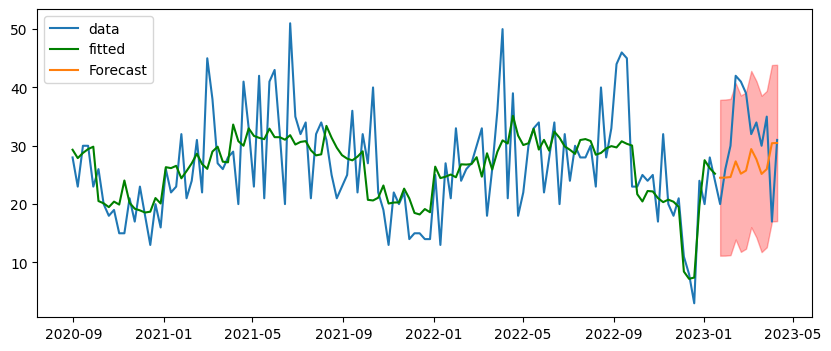

In [46]:
plot_fit_and_forecast(model_ARIMAX_fit)

**Calcular el error de la predicción**

In [48]:
#RMSE
RMSE_ARIMAX = np.sqrt(mean_squared_error(serie_suro.loc[test_idx, 'CANT_EVENTOS'], serie_suro.loc[test_idx, 'ARIMAX']))
MAE_ARIMAX = mean_absolute_error(serie_suro.loc[test_idx, 'CANT_EVENTOS'], serie_suro.loc[test_idx, 'ARIMAX'])

print("Error de la predicción")
print("ARIMAX Model RMSE: ", RMSE_ARIMAX)
print("ARIMAX Model MAE: ", MAE_ARIMAX)


Error de la predicción
ARIMAX Model RMSE:  9.232010942071893
ARIMAX Model MAE:  7.640807844284396


**Exportar los datos**

Exportar los resultados de la predicción del modelo y el intervalo de confianza

In [49]:
#obtener el intervalo de confianza de la predicción - series con los valores inrerior y superior
conf_int = prediction_ARIMAX.conf_int()
lower, upper = conf_int['lower CANT_EVENTOS'], conf_int['upper CANT_EVENTOS']

In [50]:
#crear un dataframe para almacenar los resultados de la predicción 
df_ARIMAX = serie_suro[['CANT_EVENTOS', 'ARIMAX']]

In [51]:
#agregar al dataframe las series con los valores del intervalo de confianza
df_ARIMAX = df_ARIMAX.merge(conf_int, how = 'left', left_index = True, right_index = True)

In [52]:
#Exportar los datos en archivo plano
df_ARIMAX.to_csv('/content/drive/MyDrive/ProyectoIntegrador2/datos_export/ARIMAX.csv')